In [2]:
from __future__ import print_function
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics

## Fetching data, training a classifier

For this tutorial, we'll be using the [20 newsgroups dataset](http://scikit-learn.org/stable/datasets/#the-20-newsgroups-text-dataset). In particular, for simplicity, we'll use a 2-class subset: atheism and christianity.

In [3]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

Let's use the tfidf vectorizer, commonly used for text.

In [4]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)


Now, let's say we want to use random forests for classification. It's usually hard to understand what random forests are doing, especially with many trees.

In [5]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [6]:
pred = rf.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary')

0.9241540256709451

We see that this classifier achieves a very high F score. [The sklearn guide to 20 newsgroups](http://scikit-learn.org/stable/datasets/#filtering-text-for-more-realistic-training) indicates that Multinomial Naive Bayes overfits this dataset by learning irrelevant stuff, such as headers. Let's see if random forests do the same.

## Explaining predictions using lime

Lime explainers assume that classifiers act on raw text, but sklearn classifiers act on vectorized representation of texts. For this purpose, we use sklearn's pipeline, and implements predict_proba on raw_text lists.

In [7]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

In [8]:
print(c.predict_proba([newsgroups_test.data[0]]))

[[0.252 0.748]]


Now we create an explainer object. We pass the class_names as an argument for prettier display.

In [9]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

We then generate an explanation with at most 6 features for an arbitrary document in the test set.

In [10]:
idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

/Users/amitrathi/.virtualenvs/loaded2/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Document id: 83
Probability(christian) = 0.492
True class: atheism


The classifier got this example right (it predicted atheism).  
The explanation is presented below as a list of weighted features. 

In [11]:
exp.as_list()

[('Host', -0.13158254377478837),
 ('Posting', -0.12755833682065656),
 ('NNTP', -0.1091239484180258),
 ('edu', -0.02540690605359643),
 ('post', -0.0130522416154676),
 ('Thanks', 0.009196448838747762)]

These weighted features are a linear model, which approximates the behaviour of the random forest classifier in the vicinity of the test example. Roughly, if we remove 'Posting' and 'Host' from the document , the prediction should move towards the opposite class (Christianity) by about 0.27 (the sum of the weights for both features). Let's see if this is the case.

In [12]:
print('Original prediction:', rf.predict_proba(test_vectors[idx])[0,1])
tmp = test_vectors[idx].copy()
tmp[0,vectorizer.vocabulary_['Posting']] = 0
tmp[0,vectorizer.vocabulary_['Host']] = 0
print('Prediction removing some features:', rf.predict_proba(tmp)[0,1])
print('Difference:', rf.predict_proba(tmp)[0,1] - rf.predict_proba(test_vectors[idx])[0,1])

Original prediction: 0.492
Prediction removing some features: 0.734
Difference: 0.242


Pretty close!  
The words that explain the model around this document seem very arbitrary - not much to do with either Christianity or Atheism.  
In fact, these are words that appear in the email headers (you will see this clearly soon), which make distinguishing between the classes much easier.

## Visualizing explanations

The explanations can be returned as a matplotlib barplot:

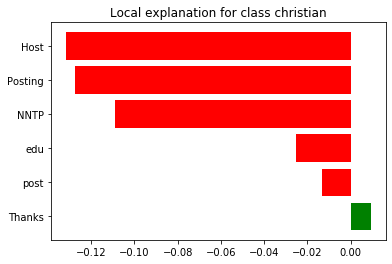

In [13]:
%matplotlib inline
fig = exp.as_pyplot_figure()


The explanations can also be exported as an html page (which we can render here in this notebook), using D3.js to render graphs.  


In [14]:
exp.show_in_notebook(text=False)

Alternatively, we can save the fully contained html page to a file:

In [14]:
exp.save_to_file('/tmp/oi.html')

Finally, we can also include a visualization of the original document, with the words in the explanations highlighted. Notice how the words that affect the classifier the most are all in the email header.

In [15]:
exp.show_in_notebook(text=True)

That's it for this tutorial. Random forests were just an example, this explainer works for any classifier you may want to use, as long as it implements predict_proba.